In [80]:
# ============================================================
#  NOTEBOOK 04 — ANALYSE & INTERPRÉTABILITÉ
#  Projet : Détection de Défauts sur Acier (Steel Defects)
#  Objectif : Analyse des performances + Visualisation avancée
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_curve,
    auc
)
from collections import defaultdict
import cv2

# ── Style global ─────
plt.rcParams.update({
    'figure.facecolor'  : '#0f0f1a',
    'axes.facecolor'    : '#1a1a2e',
    'axes.edgecolor'    : '#444',
    'axes.labelcolor'   : 'white',
    'xtick.color'       : 'white',
    'ytick.color'       : 'white',
    'text.color'        : 'white',
    'grid.color'        : '#333',
    'grid.linestyle'    : '--',
    'grid.alpha'        : 0.5,
})

PALETTE = ['#00d4ff','#ff6b6b','#ffd93d','#6bcb77',
           '#c77dff','#ff9f43','#48dbfb','#ff6b81',
           '#a29bfe','#55efc4']

**CHARGEMENT DES ARTEFACTS**

In [81]:
# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device : {DEVICE}")
if DEVICE.type == 'cuda':
    print(f"   GPU    : {torch.cuda.get_device_name(0)}")
    print(f"   VRAM   : "
          f"{torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB")

# Chemins
BASE_DIR = Path("/home/admin1/Documents/SN CNN_DEEP_LEARNING")
RESULTS  = BASE_DIR / "results"
RESULTS.mkdir(exist_ok=True)

# Classes
CLASSES = [
    'crease', 'crescent_gap', 'inclusion', 'oil_spot',
    'punching_hole', 'rolled_pit', 'silk_spot',
    'waist folding', 'water_spot', 'welding_line'
]
NUM_CLASSES = len(CLASSES)

print("✅ Configuration OK")
print(f"📁 Results : {RESULTS}")

🖥️  Device : cuda
   GPU    : NVIDIA GeForce RTX 4060 Laptop GPU
   VRAM   : 8.2 GB
✅ Configuration OK
📁 Results : /home/admin1/Documents/SN CNN_DEEP_LEARNING/results


In [82]:
# ══════════════════════════════════════════════════════════
#  CHARGEMENT CONFIG PREPROCESSING (avec classes nécessaires)
# ══════════════════════════════════════════════════════════

import torch
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image
import numpy as np
import pickle

# ── Redéfinir les classes nécessaires pour le unpickling ────
class SteelDefectDataset(Dataset):
    """Dataset compatible avec le pickle du NB02"""
    
    def __init__(self, img_dir, transform=None):
        self.img_dir   = Path(img_dir)
        self.transform = transform
        self.samples   = []
        self.labels    = []
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = np.array(Image.open(img_path).convert("RGB"))
        if self.transform:
            augmented = self.transform(image=image)
            image     = augmented["image"]
        return image, label


class TransformSubset(Dataset):
    """Applique un transform différent à un sous-ensemble"""
    
    def __init__(self, dataset, indices, transform):
        self.dataset   = dataset
        self.indices   = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        img_path, label = self.dataset.samples[self.indices[idx]]
        image = np.array(Image.open(img_path).convert("RGB"))
        if self.transform:
            augmented = self.transform(image=image)
            image     = augmented["image"]
        return image, label
    
    @property
    def labels(self):
        return [self.dataset.labels[i] for i in self.indices]


# ── Maintenant on peut charger le pickle ────────────────────
CFG_PATH = RESULTS / "preprocessing_config.pkl"

print("🔄 Chargement preprocessing config...")

with open(CFG_PATH, "rb") as f:
    cfg = pickle.load(f)

# ── Récupération des variables ─────────────────────────────
MEAN          = cfg["MEAN"]
STD           = cfg["STD"]
IMG_SIZE      = cfg["IMG_SIZE"]
BATCH_SIZE    = cfg["BATCH_SIZE"]
NUM_WORKERS   = cfg.get("NUM_WORKERS", 4)  # avec fallback
train_loader  = cfg.get("train_loader", None)
val_loader    = cfg["val_loader"]
train_dataset = cfg.get("train_dataset", None)
val_dataset   = cfg["val_dataset"]

print("✅ Config preprocessing chargée")
print(f"   Mean       : {[round(m, 3) for m in MEAN]}")
print(f"   Std        : {[round(s, 3) for s in STD]}")
print(f"   Size       : {IMG_SIZE}x{IMG_SIZE}")
print(f"   Batch size : {BATCH_SIZE}")
print(f"   Val loader : {len(val_loader)} batches")


🔄 Chargement preprocessing config...
✅ Config preprocessing chargée
   Mean       : [0.331, 0.331, 0.331]
   Std        : [0.096, 0.096, 0.096]
   Size       : 224x224
   Batch size : 32
   Val loader : 15 batches


**CHARGEMENT DU MODÈLE ENTRAÎNÉ**

In [83]:
# ═══════════════════════════
#  CHARGEMENT DU MODÈLE FINAL
# ═══════════════════════════
from torchvision import models

def build_model(backbone='resnet50', num_classes=10):
    """Reconstruit l'architecture du modèle"""
    if backbone == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=None)
        in_features = model.classifier[1].in_features
        
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.Linear(512, num_classes)
        )
    elif backbone == 'resnet50':
        model = models.resnet50(weights=None)
        in_features = model.fc.in_features
        
        model.fc = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.Linear(512, num_classes)
        )
    
    return model

# Chargement du checkpoint 
MODEL_PATH = RESULTS / "final_model.pth"

print("🔄 Chargement du modèle final...")

checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)

# Extraction des métadonnées
BACKBONE     = checkpoint.get("architecture", "resnet50")
NUM_CLASSES  = checkpoint["num_classes"]
CLASSES      = checkpoint["classes"]
CLASS2IDX    = checkpoint["class2idx"]
val_acc_saved = checkpoint.get("val_acc", 0)
val_f1_saved  = checkpoint.get("val_f1", 0)

# Reconstruction du modèle
model = build_model(backbone=BACKBONE, num_classes=NUM_CLASSES)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)
model.eval()

print("✅ Modèle chargé")
print(f"   Architecture : {BACKBONE}")
print(f"   Classes      : {NUM_CLASSES}")
print(f"   Val Acc (NB3): {val_acc_saved:.4f}")
print(f"   Val F1  (NB3): {val_f1_saved:.4f}")
print(f"   Device       : {DEVICE}")


🔄 Chargement du modèle final...
✅ Modèle chargé
   Architecture : resnet50
   Classes      : 10
   Val Acc (NB3): 0.8680
   Val F1  (NB3): 0.8054
   Device       : cuda


**GÉNÉRATION DES PRÉDICTIONS**

In [84]:
# ════════════════════════════════════════
#  GÉNÉRATION DES PRÉDICTIONS + EMBEDDINGS
# ════════════════════════════════════════
from tqdm import tqdm

@torch.no_grad()
def get_predictions_and_embeddings(model, loader, device):
    """
    Génère prédictions + embeddings pour analyse avancée
    
    Returns:
        all_preds    : np.array (N,) - classes prédites
        all_labels   : np.array (N,) - vraies classes
        all_probs    : np.array (N, num_classes) - probabilités
        all_embeddings : np.array (N, 512) - features de la couche fc
    """
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    all_embeddings = []
    
    # Hook pour capturer les embeddings
    embeddings_cache = []
    
    def hook_fn(module, input, output):
        # Capture la sortie avant la dernière couche
        embeddings_cache.append(input[0].cpu().numpy())
    
    # Attacher le hook à la dernière Linear
    if BACKBONE == 'resnet50':
        hook = model.fc[-1].register_forward_hook(hook_fn)
    else:  # efficientnet
        hook = model.classifier[-1].register_forward_hook(hook_fn)
    
    # Boucle de prédiction
    for images, labels in tqdm(loader, desc="🔮 Prédictions"):
        images = images.to(device)
        
        outputs = model(images)
        probs   = torch.softmax(outputs, dim=1)
        preds   = probs.argmax(dim=1)
        
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.numpy())
        all_probs.append(probs.cpu().numpy())
    
    # Détacher le hook
    hook.remove()
    
    # Concaténation
    all_preds  = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_probs  = np.concatenate(all_probs)
    all_embeddings = np.concatenate(embeddings_cache, axis=0)
    
    return all_preds, all_labels, all_probs, all_embeddings

# Exécution
print("\n" + "="*60)
print("  GÉNÉRATION DES PRÉDICTIONS")
print("="*60)

preds, labels, probs, embeddings = get_predictions_and_embeddings(
    model, val_loader, DEVICE
)

print(f"\n✅ Prédictions générées")
print(f"   Samples     : {len(preds)}")
print(f"   Embeddings  : {embeddings.shape}")
print(f"   Probs shape : {probs.shape}")



  GÉNÉRATION DES PRÉDICTIONS


🔮 Prédictions: 100%|██████████| 15/15 [00:02<00:00,  6.55it/s]


✅ Prédictions générées
   Samples     : 462
   Embeddings  : (462, 512)
   Probs shape : (462, 10)


**RAPPORT DE CLASSIFICATION**

In [85]:
# ═══════════════════════════════════
#  RAPPORT DE CLASSIFICATION DÉTAILLÉ
# ═══════════════════════════════════

from sklearn.metrics import classification_report, accuracy_score

# Métriques globales
accuracy = accuracy_score(labels, preds)
report   = classification_report(
    labels, preds, 
    target_names=CLASSES, 
    digits=4,
    output_dict=True
)

# Affichage formaté
print("\n" + "="*70)
print("  📊 RAPPORT DE CLASSIFICATION")
print("="*70)
print(f"\n🎯 Accuracy globale : {accuracy:.4f}\n")

print("─"*70)
print(f"{'Classe':<20} {'Precision':>10} {'Recall':>10} "
      f"{'F1-Score':>10} {'Support':>10}")
print("─"*70)

for cls in CLASSES:
    p = report[cls]['precision']
    r = report[cls]['recall']
    f = report[cls]['f1-score']
    s = int(report[cls]['support'])
    
    print(f"{cls:<20} {p:>10.4f} {r:>10.4f} {f:>10.4f} {s:>10}")

print("─"*70)
print(f"{'Macro Avg':<20} "
      f"{report['macro avg']['precision']:>10.4f} "
      f"{report['macro avg']['recall']:>10.4f} "
      f"{report['macro avg']['f1-score']:>10.4f} "
      f"{int(report['macro avg']['support']):>10}")

print(f"{'Weighted Avg':<20} "
      f"{report['weighted avg']['precision']:>10.4f} "
      f"{report['weighted avg']['recall']:>10.4f} "
      f"{report['weighted avg']['f1-score']:>10.4f} "
      f"{int(report['weighted avg']['support']):>10}")
print("="*70)



  📊 RAPPORT DE CLASSIFICATION

🎯 Accuracy globale : 0.8680

──────────────────────────────────────────────────────────────────────
Classe                Precision     Recall   F1-Score    Support
──────────────────────────────────────────────────────────────────────
crease                   0.7000     0.6364     0.6667         11
crescent_gap             0.8333     1.0000     0.9091         45
inclusion                0.7391     0.7907     0.7640         43
oil_spot                 0.8649     0.7805     0.8205         41
punching_hole            0.7959     0.8864     0.8387         44
rolled_pit               0.4000     0.6667     0.5000          6
silk_spot                0.9615     0.9615     0.9615        130
waist folding            0.9310     0.9310     0.9310         29
water_spot               0.9123     0.8966     0.9043         58
welding_line             0.9000     0.6545     0.7579         55
──────────────────────────────────────────────────────────────────────
Macro Avg  

**MATRICE DE CONFUSION**

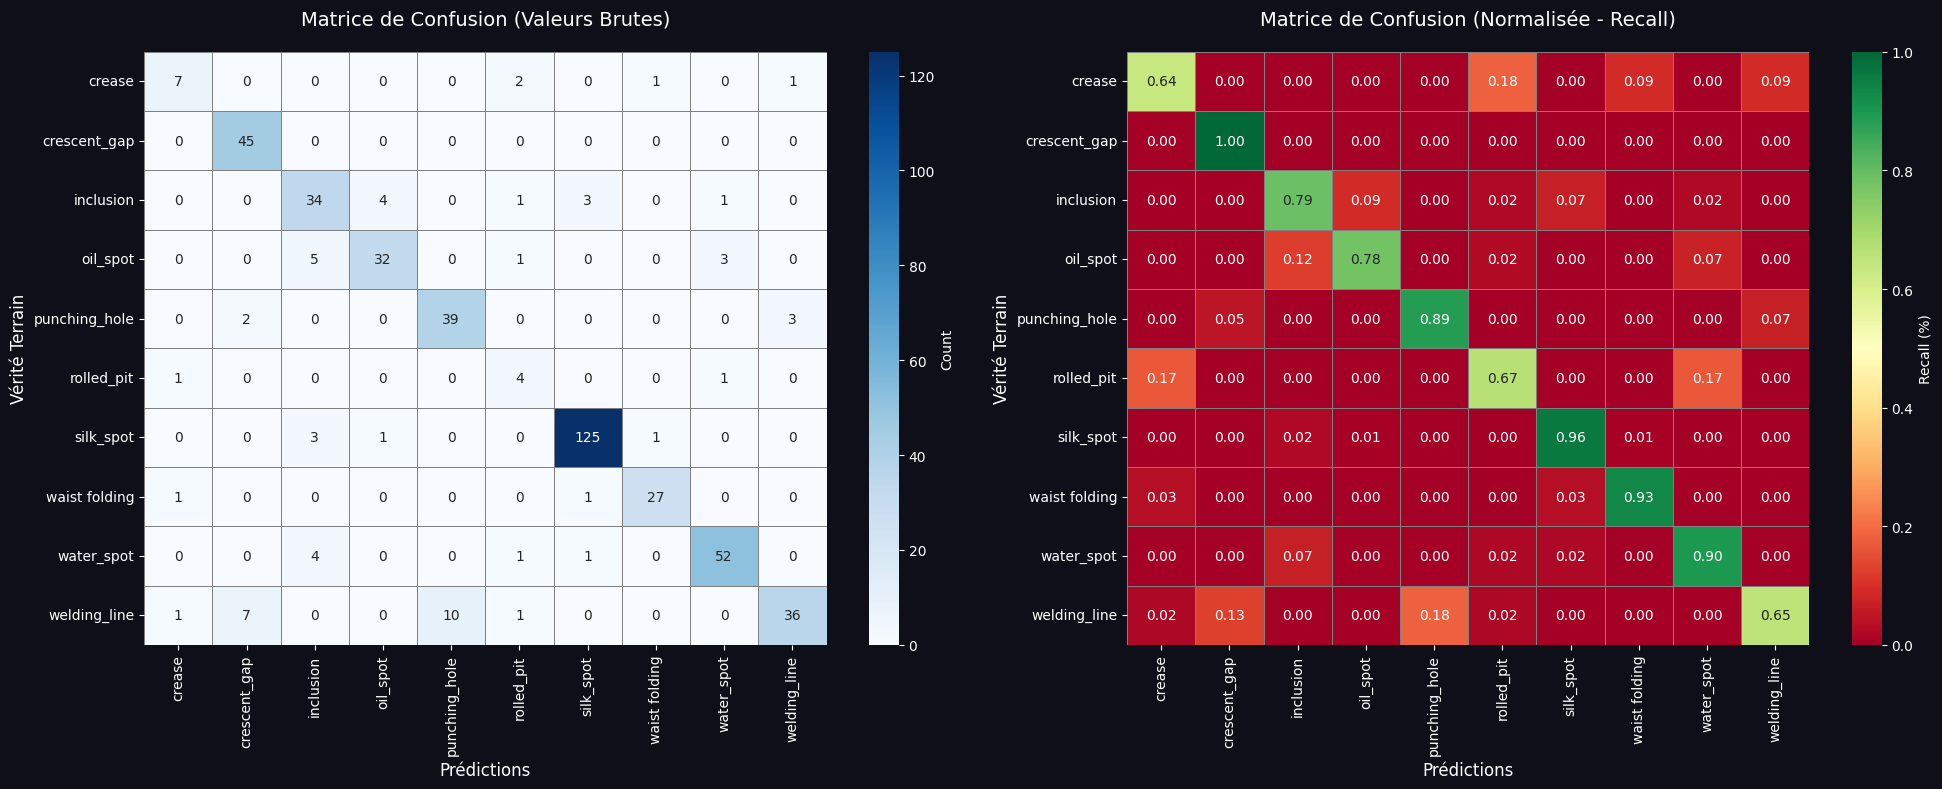

💾 Matrice de confusion sauvegardée


In [86]:
# ═════════════════════
#  MATRICE DE CONFUSION 
# ═════════════════════

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, preds)

# Normalisation par ligne (recall)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Matrice brute
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=CLASSES, yticklabels=CLASSES,
    cbar_kws={'label': 'Count'},
    ax=axes[0],
    linewidths=0.5,
    linecolor='gray'
)
axes[0].set_title("Matrice de Confusion (Valeurs Brutes)", 
                  fontsize=14, pad=20, color='white')
axes[0].set_xlabel("Prédictions", fontsize=12)
axes[0].set_ylabel("Vérité Terrain", fontsize=12)

# Matrice normalisée
sns.heatmap(
    cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn',
    xticklabels=CLASSES, yticklabels=CLASSES,
    cbar_kws={'label': 'Recall (%)'},
    ax=axes[1],
    linewidths=0.5,
    linecolor='gray',
    vmin=0, vmax=1
)
axes[1].set_title("Matrice de Confusion (Normalisée - Recall)", 
                  fontsize=14, pad=20, color='white')
axes[1].set_xlabel("Prédictions", fontsize=12)
axes[1].set_ylabel("Vérité Terrain", fontsize=12)

plt.tight_layout()
plt.savefig(RESULTS / "confusion_matrix_detailed.png", 
            dpi=150, bbox_inches='tight')
plt.show()

print("💾 Matrice de confusion sauvegardée")

**ANALYSE DES CONFUSIONS**

In [87]:
# ═════════════════════
#  TOP 5 DES CONFUSIONS
# ═════════════════════

# Extraire les erreurs (hors diagonale)
confusions = []

for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if i != j and cm[i, j] > 0:
            confusions.append({
                'true': CLASSES[i],
                'pred': CLASSES[j],
                'count': cm[i, j],
                'rate': cm_normalized[i, j]
            })

# Trier par count
confusions_sorted = sorted(confusions, key=lambda x: x['count'], reverse=True)

print("\n" + "="*70)
print("  ❌ TOP 5 DES CONFUSIONS")
print("="*70)

for idx, conf in enumerate(confusions_sorted[:5], 1):
    print(f"\n{idx}. {conf['true']} → {conf['pred']}")
    print(f"   Occurrences : {conf['count']}")
    print(f"   Taux erreur : {conf['rate']*100:.2f}%")



  ❌ TOP 5 DES CONFUSIONS

1. welding_line → punching_hole
   Occurrences : 10
   Taux erreur : 18.18%

2. welding_line → crescent_gap
   Occurrences : 7
   Taux erreur : 12.73%

3. oil_spot → inclusion
   Occurrences : 5
   Taux erreur : 12.20%

4. inclusion → oil_spot
   Occurrences : 4
   Taux erreur : 9.30%

5. water_spot → inclusion
   Occurrences : 4
   Taux erreur : 6.90%


**GRAD-CAM (Interprétabilité visuelle)**

In [88]:
# ══════════════════════════════════════════════
#  GRAD-CAM :VISUALISATION DES ZONES D'ATTENTION
# ══════════════════════════════════════════════
import cv2
class GradCAM:
    """
    Grad-CAM pour visualiser les zones d'attention du modèle
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Hooks pour capturer gradients et activations
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def __call__(self, x, class_idx=None):
        """
        Génère la Grad-CAM
        
        Args:
            x: Tensor (1, 3, H, W)
            class_idx: Classe cible (si None, utilise la prédiction)
        
        Returns:
            cam: np.array (H, W) - heatmap normalisée [0, 1]
        """
        self.model.eval()
        
        # Forward pass
        output = self.model(x)
        
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        # Backward pass sur la classe cible
        self.model.zero_grad()
        class_score = output[:, class_idx]
        class_score.backward()
        
        # Calcul de la Grad-CAM
        gradients = self.gradients[0]  # (C, H, W)
        activations = self.activations[0]  # (C, H, W)
        
        # Pondération des canaux par leurs gradients moyens
        weights = gradients.mean(dim=(1, 2))  # (C,)
        
        # Combinaison pondérée
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        # ReLU + normalisation
        cam = torch.clamp(cam, min=0)
        cam = cam.cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        return cam


def denormalize(tensor, mean, std):
    """Dénormalise un tensor pour affichage"""
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    img = tensor.cpu().numpy() * std + mean
    img = np.clip(img, 0, 1)
    return np.transpose(img, (1, 2, 0))


def overlay_heatmap(img, cam, alpha=0.4):
    """
    Superpose la heatmap sur l'image
    
    Args:
        img: np.array (H, W, 3) RGB [0, 1]
        cam: np.array (H, W) [0, 1]
        alpha: transparence de la heatmap
    
    Returns:
        overlay: np.array (H, W, 3) RGB [0, 1]
    """
    # Resize cam à la taille de l'image
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))
    
    # Convertir en heatmap colorée
    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam_resized), 
        cv2.COLORMAP_JET
    )
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    
    # Superposer
    overlay = heatmap * alpha + img * (1 - alpha)
    overlay = np.clip(overlay, 0, 1)
    
    return overlay


# Initialisation Grad-CAM 
if BACKBONE == 'resnet50':
    target_layer = model.layer4[-1]  # Dernière couche conv
elif BACKBONE == 'efficientnet_b0':
    target_layer = model.features[-1]  # Dernière couche conv

grad_cam = GradCAM(model, target_layer)

print("✅ Grad-CAM initialisé")
print(f"   Target layer : {target_layer.__class__.__name__}")


✅ Grad-CAM initialisé
   Target layer : Bottleneck


**VISUALISATION GRAD-CAM (Correctes & Erreurs)**

In [89]:
# ══════════════════════════════════════════════════════════
#  CLASSE GRAD-CAM CORRIGÉE (Device-Safe)
# ══════════════════════════════════════════════════════════

class GradCAM:
    """
    Grad-CAM pour visualiser les zones d'attention du modèle
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Hooks pour capturer gradients et activations
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def __call__(self, x, class_idx=None):
        """
        Génère la Grad-CAM
        
        Args:
            x: Tensor (1, 3, H, W) sur GPU
            class_idx: Classe cible (si None, utilise la prédiction)
        
        Returns:
            cam: np.array (H, W) - heatmap normalisée [0, 1]
        """
        self.model.eval()
        
        # Forward pass
        output = self.model(x)
        
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        # Backward pass sur la classe cible
        self.model.zero_grad()
        class_score = output[:, class_idx]
        class_score.backward()
        
        # Calcul de la Grad-CAM
        gradients = self.gradients[0]  # (C, H, W) sur GPU
        activations = self.activations[0]  # (C, H, W) sur GPU
        
        # Pondération des canaux par leurs gradients moyens
        weights = gradients.mean(dim=(1, 2))  # (C,) sur GPU
        
        # ⚠️ CORRECTION : Initialiser cam sur le même device que activations
        cam = torch.zeros(
            activations.shape[1:], 
            dtype=torch.float32,
            device=activations.device  # ← FIX : utiliser le device de activations
        )
        
        # Combinaison pondérée
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        # ReLU + normalisation
        cam = torch.clamp(cam, min=0)
        cam = cam.cpu().numpy()  # ← Conversion vers CPU uniquement ici
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        return cam


# ══════════════════════════════════════════════════════════
#  FONCTIONS UTILITAIRES
# ══════════════════════════════════════════════════════════

def denormalize(tensor, mean, std):
    """Dénormalise un tensor pour affichage"""
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    img = tensor.cpu().numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return np.transpose(img, (1, 2, 0))


def overlay_heatmap(img, cam, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """
    Superpose la heatmap sur l'image
    
    Args:
        img: np.array (H, W, 3) RGB [0, 1]
        cam: np.array (H', W') [0, 1]
        alpha: Transparence de la heatmap
    
    Returns:
        overlay: np.array (H, W, 3) RGB [0, 1]
    """
    H, W = img.shape[:2]
    
    # Redimensionner la CAM à la taille de l'image
    cam_resized = cv2.resize(cam, (W, H))
    
    # Convertir en heatmap colorée
    cam_uint8 = np.uint8(255 * cam_resized)
    heatmap = cv2.applyColorMap(cam_uint8, colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    
    # Superposition
    overlay = alpha * heatmap + (1 - alpha) * img
    overlay = np.clip(overlay, 0, 1)
    
    return overlay


# ══════════════════════════════════════════════════════════
#  INITIALISATION GRAD-CAM
# ══════════════════════════════════════════════════════════

# Déterminer la couche cible selon le backbone
if BACKBONE == 'efficientnet_b0':
    target_layer = model.features[-1]  # Dernière couche conv
elif BACKBONE == 'resnet50':
    target_layer = model.layer4[-1]  # Dernière couche ResNet
else:
    raise ValueError(f"Backbone {BACKBONE} non supporté pour Grad-CAM")

grad_cam = GradCAM(model, target_layer)

print("✅ Grad-CAM initialisé (Device-Safe)")
print(f"   Target layer : {target_layer.__class__.__name__}")
print(f"   Device : {next(model.parameters()).device}")


# ════════════
#  TEST RAPIDE
# ════════════

print("\n🔍 Test Grad-CAM sur 1 image :")

# Prendre la première image
img_tensor, label = val_dataset[0]
img_tensor = img_tensor.unsqueeze(0).to(DEVICE)

try:
    cam = grad_cam(img_tensor, class_idx=label)
    print(f"   ✅ CAM shape : {cam.shape}")
    print(f"   ✅ CAM range : [{cam.min():.3f}, {cam.max():.3f}]")
    print(f"   ✅ CAM dtype : {cam.dtype}")
except Exception as e:
    print(f"   ❌ Erreur : {e}")
    import traceback
    traceback.print_exc()


✅ Grad-CAM initialisé (Device-Safe)
   Target layer : Bottleneck
   Device : cuda:0

🔍 Test Grad-CAM sur 1 image :
   ✅ CAM shape : (7, 7)
   ✅ CAM range : [0.000, 1.000]
   ✅ CAM dtype : float32



  🎨 GÉNÉRATION DES GRAD-CAM

📊 Classes sélectionnées pour Grad-CAM :
   - silk_spot            : 125 corrects,   5 erreurs
   - water_spot           :  52 corrects,   6 erreurs
   - welding_line         :  36 corrects,  19 erreurs
   - crescent_gap         :  45 corrects,   0 erreurs


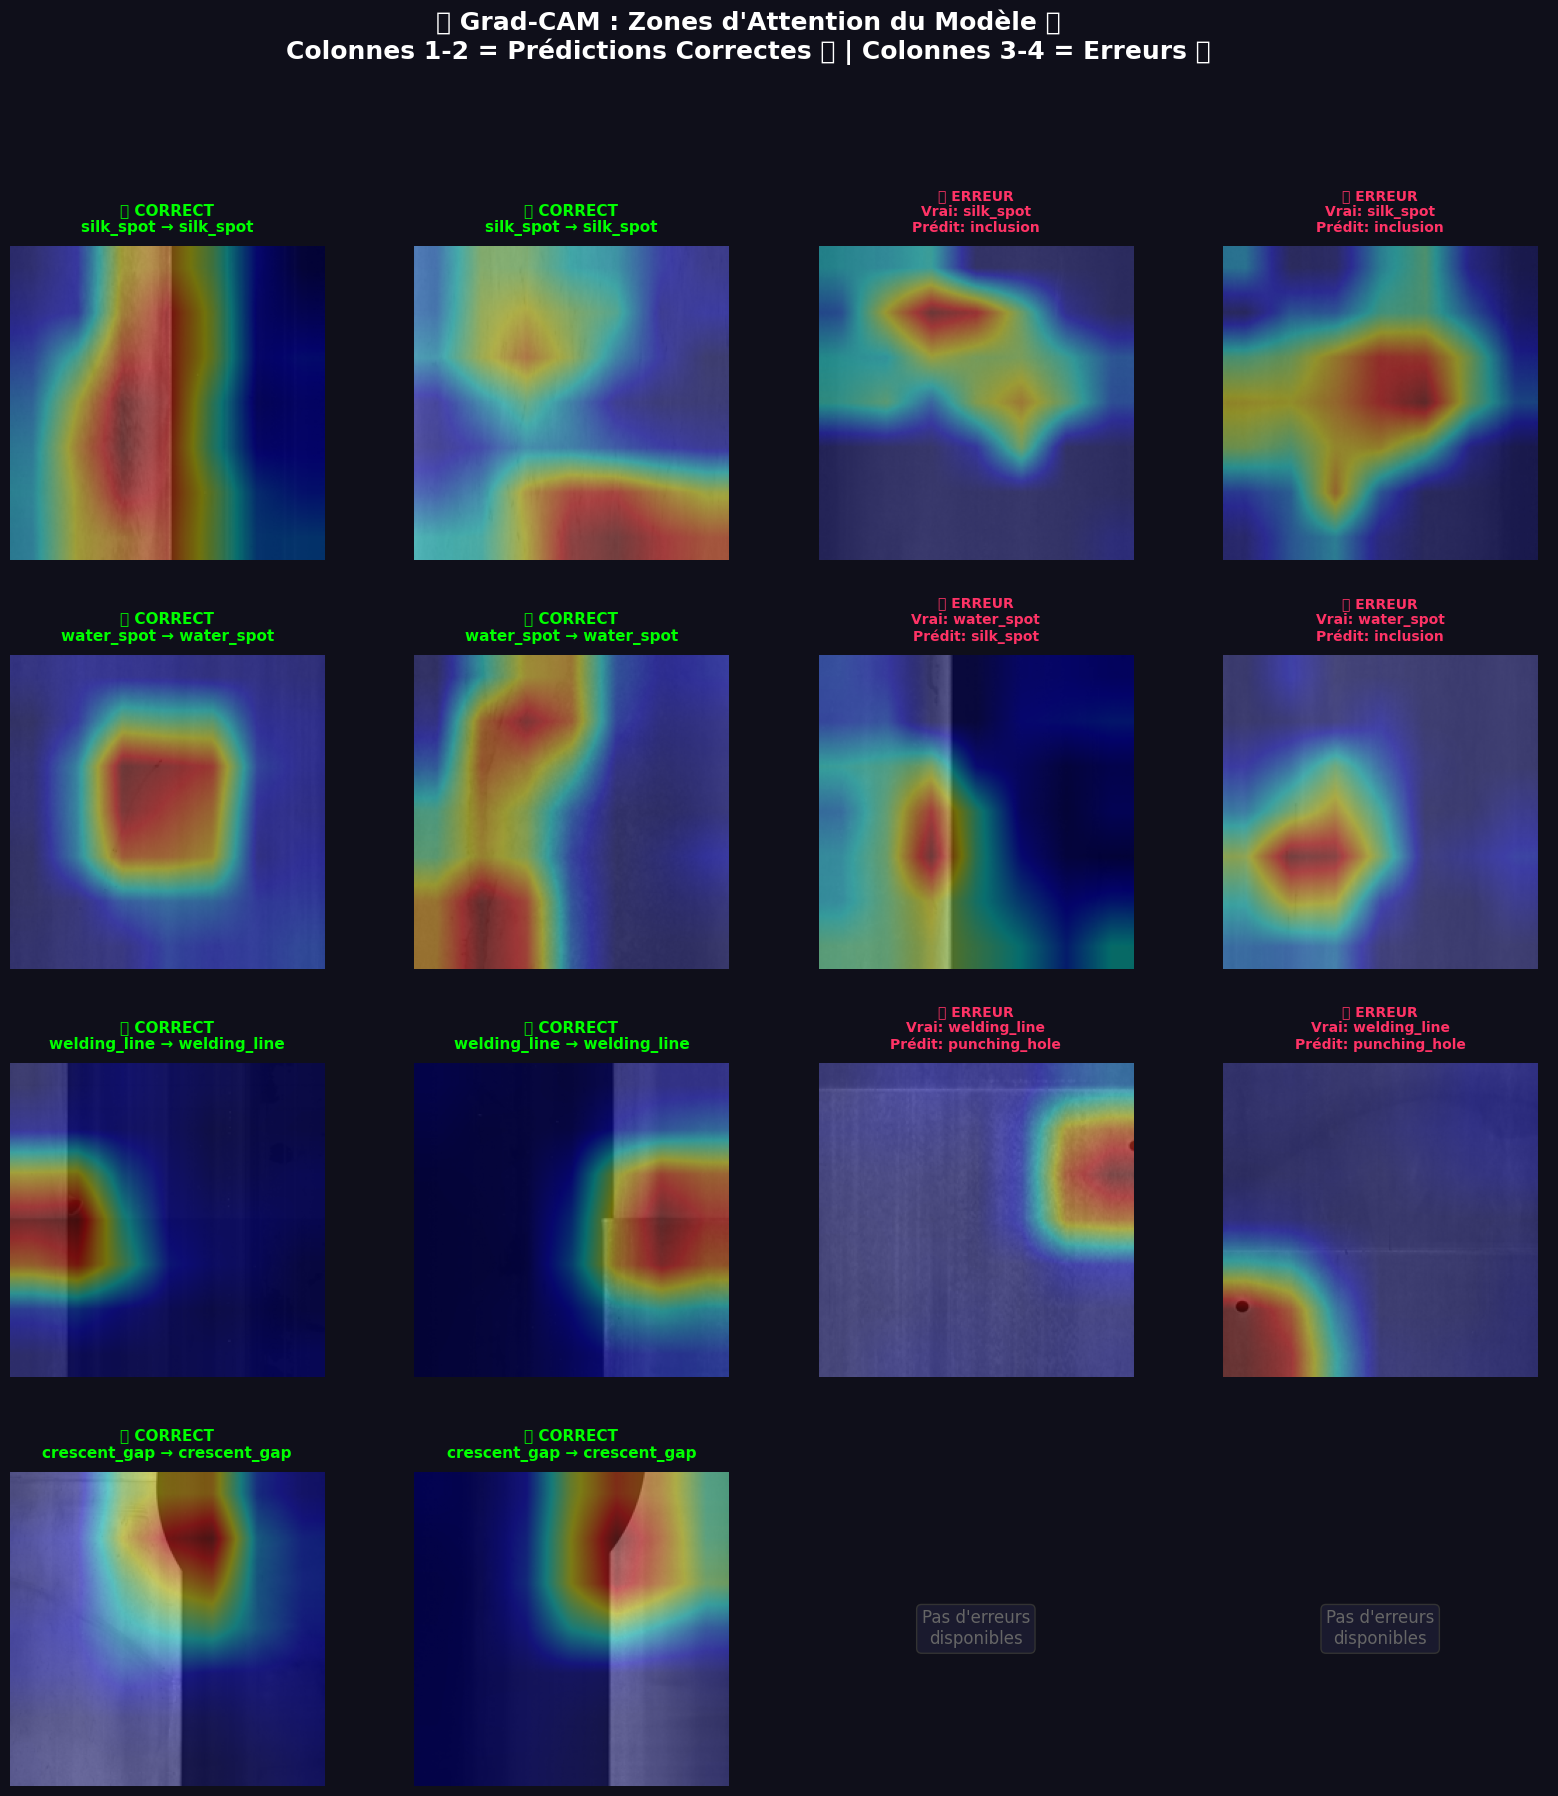


💾 Grad-CAM sauvegardé → gradcam_analysis.png


In [90]:
# ════════════════════════════════
#  VISUALISATION GRAD-CAM COMPLÈTE
# ════════════════════════════════

def get_original_image(dataset, idx):
    """Récupère l'image originale depuis le dataset"""
    if hasattr(dataset, 'dataset'):
        global_idx = dataset.indices[idx]
        base_dataset = dataset.dataset
        img_path, _ = base_dataset.samples[global_idx]
    else:
        img_path, _ = dataset.samples[idx]
    
    img_original = Image.open(img_path).convert("RGB")
    img_original = np.array(img_original.resize((IMG_SIZE, IMG_SIZE))) / 255.0
    return img_original, img_path


def visualize_gradcam_samples(
    model, grad_cam, loader, dataset, 
    preds, labels, num_per_class=2
):
    """Affiche Grad-CAM pour échantillons corrects et incorrects"""
    
    # Collecte des indices
    correct_indices = defaultdict(list)
    error_indices = defaultdict(list)
    
    for idx in range(len(preds)):
        true_label = labels[idx]
        pred_label = preds[idx]
        
        if pred_label == true_label:
            correct_indices[true_label].append(idx)
        else:
            error_indices[true_label].append(idx)
    
    # Sélection des classes représentatives 
    class_counts = [(cls, len(correct_indices[cls]) + len(error_indices[cls])) 
                    for cls in range(NUM_CLASSES)]
    class_counts_sorted = sorted(class_counts, key=lambda x: x[1], reverse=True)
    selected_classes = [cls for cls, _ in class_counts_sorted[:4]]
    
    print(f"\n📊 Classes sélectionnées pour Grad-CAM :")
    for cls in selected_classes:
        n_correct = len(correct_indices[cls])
        n_errors = len(error_indices[cls])
        print(f"   - {CLASSES[cls]:20s} : {n_correct:3d} corrects, {n_errors:3d} erreurs")
    
    # Visualisation
    fig = plt.figure(figsize=(20, 5 * len(selected_classes)))
    fig.patch.set_facecolor('#0f0f1a')
    
    gs = gridspec.GridSpec(
        len(selected_classes), 4, 
        figure=fig, 
        hspace=0.3, wspace=0.2
    )
    
    for row_idx, cls_idx in enumerate(selected_classes):
        cls_name = CLASSES[cls_idx]
        
        # ──────────────────────────────────────────────────
        # 2 PRÉDICTIONS CORRECTES (colonnes 0-1)
        # ──────────────────────────────────────────────────
        for col in range(2):
            ax = fig.add_subplot(gs[row_idx, col])
            ax.set_facecolor('#0f0f1a')
            
            if col < len(correct_indices[cls_idx]):
                idx = correct_indices[cls_idx][col]
                
                # Image originale
                img_original, img_path = get_original_image(dataset, idx)
                
                # Tensor transformé
                img_tensor, _ = dataset[idx]
                img_tensor = img_tensor.unsqueeze(0).to(DEVICE)
                
                # Grad-CAM
                cam = grad_cam(img_tensor, class_idx=cls_idx)
                overlay = overlay_heatmap(img_original, cam, alpha=0.4)
                
                # Plot
                ax.imshow(overlay)
                ax.set_title(
                    f"✅ CORRECT\n{cls_name} → {cls_name}",
                    fontsize=11, color='#00ff00', fontweight='bold',
                    pad=10
                )
            else:
                ax.text(0.5, 0.5, "Pas assez\nd'échantillons", 
                       ha='center', va='center', 
                       fontsize=12, color='#666666',
                       bbox=dict(boxstyle='round', facecolor='#1a1a2e', 
                                edgecolor='#333333'))
            
            ax.axis('off')
        
        # ──────────────────────────────────────────────────
        # 2 PRÉDICTIONS INCORRECTES (colonnes 2-3)
        # ──────────────────────────────────────────────────
        for col in range(2):
            ax = fig.add_subplot(gs[row_idx, col + 2])
            ax.set_facecolor('#0f0f1a')
            
            if col < len(error_indices[cls_idx]):
                idx = error_indices[cls_idx][col]
                
                # Image
                img_original, img_path = get_original_image(dataset, idx)
                img_tensor, _ = dataset[idx]
                img_tensor = img_tensor.unsqueeze(0).to(DEVICE)
                
                # Grad-CAM sur la classe prédite (pas la vraie)
                pred_cls = preds[idx]
                cam = grad_cam(img_tensor, class_idx=pred_cls)
                overlay = overlay_heatmap(img_original, cam, alpha=0.4)
                
                # Plot
                ax.imshow(overlay)
                ax.set_title(
                    f"❌ ERREUR\nVrai: {cls_name}\nPrédit: {CLASSES[pred_cls]}",
                    fontsize=10, color='#ff3366', fontweight='bold',
                    pad=10
                )
            else:
                ax.text(0.5, 0.5, "Pas d'erreurs\ndisponibles", 
                       ha='center', va='center', 
                       fontsize=12, color='#666666',
                       bbox=dict(boxstyle='round', facecolor='#1a1a2e', 
                                edgecolor='#333333'))
            
            ax.axis('off')
    
    # Titre global 
    plt.suptitle(
        "🔥 Grad-CAM : Zones d'Attention du Modèle 🔥\n"
        "Colonnes 1-2 = Prédictions Correctes ✅ | Colonnes 3-4 = Erreurs ❌",
        fontsize=18, fontweight='bold', color='white', y=0.998
    )
    
    plt.savefig(
        RESULTS / "gradcam_analysis.png", 
        dpi=150, 
        bbox_inches='tight',
        facecolor='#0f0f1a'
    )
    plt.show()
    
    print("\n" + "="*60)
    print("💾 Grad-CAM sauvegardé → gradcam_analysis.png")
    print("="*60)

# ══════════
#  EXÉCUTION
# ══════════
print("\n" + "="*60)
print("  🎨 GÉNÉRATION DES GRAD-CAM")
print("="*60)

visualize_gradcam_samples(
    model, grad_cam, val_loader, val_dataset,
    preds, labels, num_per_class=2
)

**Extraction des Embeddings**

In [91]:
# ══════════════════════════
#  EXTRACTION DES EMBEDDINGS
# ══════════════════════════

def extract_embeddings(model, loader, device):
    """
    Extrait les features avant la couche FC
    
    Returns:
        embeddings: np.array (N, 512)
        labels: np.array (N,)
        predictions: np.array (N,)
    """
    model.eval()
    
    embeddings_list = []
    labels_list = []
    predictions_list = []
    
    # Hook pour capturer les features
    features_hook = []
    
    def hook_fn(module, input, output):
        features_hook.append(output.detach())
    
    # Enregistrer le hook sur avgpool (avant la FC)
    if BACKBONE == 'resnet50':
        handle = model.avgpool.register_forward_hook(hook_fn)
    elif BACKBONE == 'efficientnet_b0':
        handle = model.avgpool.register_forward_hook(hook_fn)
    else:
        raise ValueError(f"Backbone {BACKBONE} non supporté")
    
    print("🔄 Extraction des embeddings...")
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(loader, desc="Extraction")):
            inputs = inputs.to(device)
            
            # Forward pass
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            
            # Récupérer les features via le hook
            features = features_hook[-1]
            features = features.view(features.size(0), -1)  # Flatten
            
            embeddings_list.append(features.cpu().numpy())
            labels_list.append(targets.numpy())
            predictions_list.append(preds.cpu().numpy())
            
            features_hook.clear()
    
    handle.remove()
    
    # Concaténation
    embeddings = np.concatenate(embeddings_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    predictions = np.concatenate(predictions_list, axis=0)
    
    print(f"✅ Embeddings extraits : {embeddings.shape}")
    print(f"   Labels : {labels.shape}")
    print(f"   Predictions : {predictions.shape}")
    
    return embeddings, labels, predictions

# Exécution
embeddings, true_labels, pred_labels = extract_embeddings(
    model, val_loader, DEVICE
)


🔄 Extraction des embeddings...


Extraction: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s]

✅ Embeddings extraits : (462, 2048)
   Labels : (462,)
   Predictions : (462,)


**Réduction t-SNE en 2D**

In [92]:
# ═════════════════════════
#  CALCUL t-SNE (512D → 2D)
# ═════════════════════════
from sklearn.manifold import TSNE

print("\n" + "="*60)
print("  📉 CALCUL t-SNE (peut prendre 2-3 minutes)")
print("="*60)

# Sous-échantillonnage si > 5000 samples (pour accélérer)
MAX_SAMPLES = 5000
if len(embeddings) > MAX_SAMPLES:
    print(f"⚠️  Sous-échantillonnage : {len(embeddings)} → {MAX_SAMPLES} samples")
    indices = np.random.choice(len(embeddings), MAX_SAMPLES, replace=False)
    embeddings_subset = embeddings[indices]
    labels_subset = true_labels[indices]
    preds_subset = pred_labels[indices]
else:
    embeddings_subset = embeddings
    labels_subset = true_labels
    preds_subset = pred_labels

# t-SNE avec les bons paramètres
tsne = TSNE(
    n_components=2,
    perplexity=30,              # Nombre de voisins (15-50)
    learning_rate=200,          # Vitesse de convergence
    max_iter=1000,              # ⚠️ CORRECTION : max_iter au lieu de n_iter
    random_state=42,
    verbose=1
)

print("🔄 Calcul t-SNE en cours...")
embeddings_2d = tsne.fit_transform(embeddings_subset)

print(f"✅ t-SNE terminé : {embeddings_2d.shape}")
print(f"   KL divergence : {tsne.kl_divergence_:.4f} (plus c'est bas, mieux c'est)")



  📉 CALCUL t-SNE (peut prendre 2-3 minutes)
🔄 Calcul t-SNE en cours...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 462 samples in 0.000s...
[t-SNE] Computed neighbors for 462 samples in 0.137s...
[t-SNE] Computed conditional probabilities for sample 462 / 462
[t-SNE] Mean sigma: 6.478999
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.085785
[t-SNE] KL divergence after 1000 iterations: 0.567964
✅ t-SNE terminé : (462, 2)
   KL divergence : 0.5680 (plus c'est bas, mieux c'est)


**Visualisation par Classe**

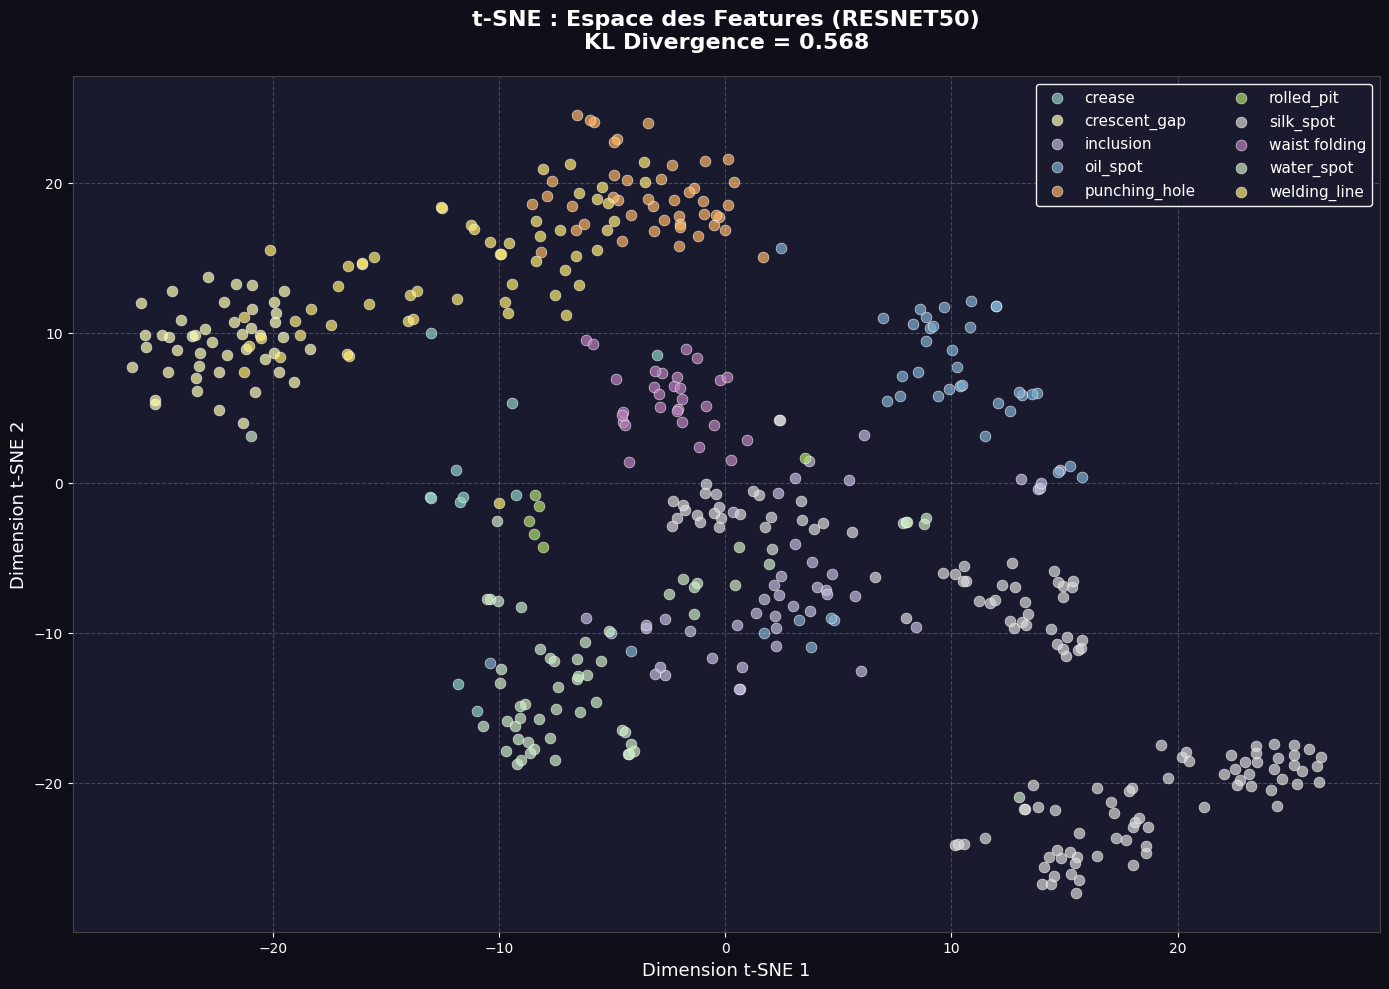

💾 Graphique 1/2 sauvegardé → tsne_classes.png


In [93]:
# ═══════════════════════════════════
#  VISUALISATION 1 : t-SNE PAR CLASSE
# ═══════════════════════════════════

fig, ax = plt.subplots(figsize=(14, 10), facecolor='#0f0f1a')
ax.set_facecolor('#1a1a2e')

# Palette de couleurs
colors = plt.cm.Set3(np.linspace(0, 1, NUM_CLASSES))

# Plot chaque classe
for class_idx in range(NUM_CLASSES):
    mask = labels_subset == class_idx
    ax.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        c=[colors[class_idx]],
        label=CLASSES[class_idx],  # ⚠️ CORRECTION : CLASSES au lieu de CLASS_NAMES
        alpha=0.7,
        s=60,
        edgecolors='white',
        linewidth=0.5
    )

# Style
ax.set_title(
    f"t-SNE : Espace des Features ({BACKBONE.upper()})\n"
    f"KL Divergence = {tsne.kl_divergence_:.3f}",
    fontsize=16, fontweight='bold', color='white', pad=20
)
ax.set_xlabel("Dimension t-SNE 1", fontsize=13, color='white')
ax.set_ylabel("Dimension t-SNE 2", fontsize=13, color='white')
ax.legend(
    loc='best',
    fontsize=11,
    framealpha=0.95,
    facecolor='#1a1a2e',
    edgecolor='white',
    ncol=2
)
ax.grid(True, alpha=0.2, color='white', linestyle='--')
ax.tick_params(colors='white', labelsize=10)

plt.tight_layout()
plt.savefig(
    RESULTS / "tsne_classes.png",
    dpi=200,
    bbox_inches='tight',
    facecolor='#0f0f1a'
)
plt.show()

print("💾 Graphique 1/2 sauvegardé → tsne_classes.png")
